In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

In [2]:
m, b = 4.66402766, 2.22976949
m_err, b_err = 0.00618106, 1.384337

## Lead

/var/folders/lz/3l45kw_56ln6k0x68wfrb0th0000gn/T/ipykernel_48031/4220234592.py:17: RuntimeWarning: divide by zero encountered in log
  y = np.log(rate)


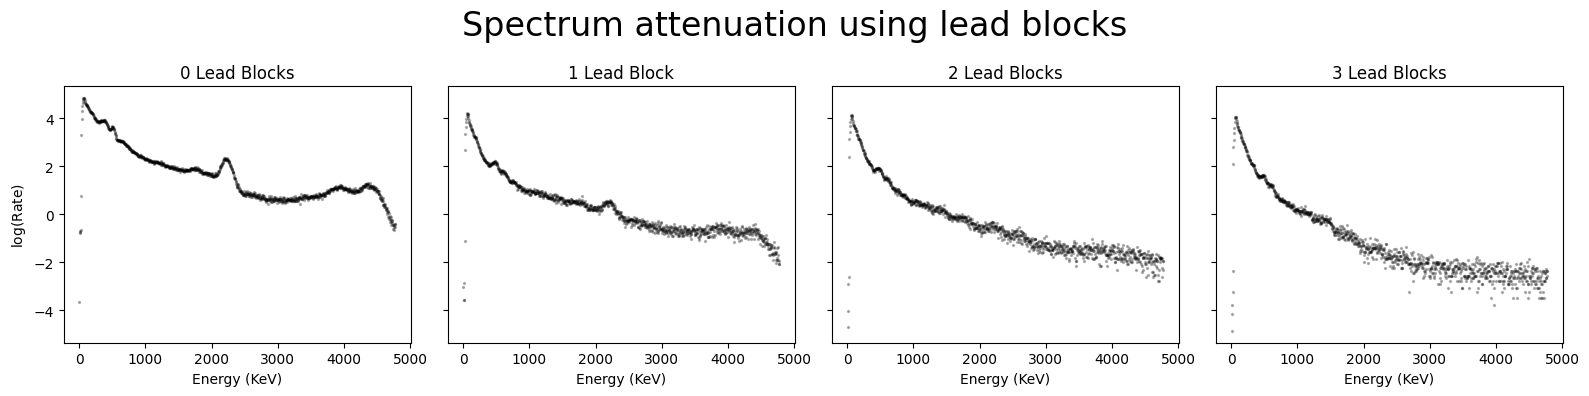

In [3]:
regions = [
    ('0 Lead Blocks', './data/pu-unplugged.csv'), 
    ('1 Lead Block', './data/pu-unplugged-lead1.csv'), 
    ('2 Lead Blocks', './data/pu-unplugged-lead2.csv'), 
    ('3 Lead Blocks', './data/pu-unplugged-lead3.csv'), 
]

fig, axs = plt.subplots(1, len(regions), figsize=(4 * len(regions), 4), sharey=True)

for ax, (title, fname) in zip(axs, regions):
    
    time, channels, counts = parse_usx_csv(fname)
    rate = counts / time
    rate_err = np.sqrt((counts / time**2) + (counts**2 * 0.1**2 / time**4))
    
    x = m * channels + b
    y = np.log(rate)

    ax.scatter(x, y, color='k', s=2, alpha=0.25)
    ax.set_title(title)
    ax.set_xlabel('Energy (KeV)')

axs[0].set_ylabel(r'$\log ( \text{Rate})$')

fig.suptitle('Spectrum attenuation using lead blocks', fontsize=24)
plt.tight_layout()

fig.savefig('./figures/lead_attenuation.pdf')

Something has gone wrong: Residuals are not finite in the initial point.


/var/folders/lz/3l45kw_56ln6k0x68wfrb0th0000gn/T/ipykernel_48031/978791188.py:19: RuntimeWarning: divide by zero encountered in reciprocal
  ( (spectrum/time**2) + (spectrum**2) * (0.1**2)/(time**4) ) ** -1
/var/folders/lz/3l45kw_56ln6k0x68wfrb0th0000gn/T/ipykernel_48031/978791188.py:26: RuntimeWarning: invalid value encountered in multiply
  (spectrum * spectrum_weight).sum(axis=1) / spectrum_weight.sum(axis=1)


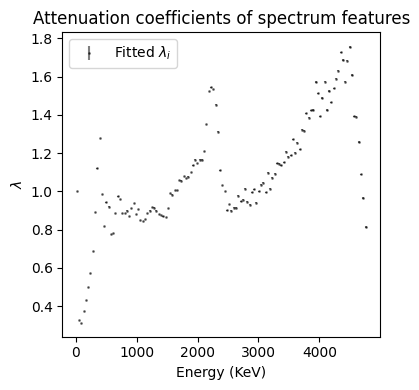

In [4]:
fnames = [
    './data/pu-unplugged.csv', 
    './data/pu-unplugged-lead1.csv', 
    './data/pu-unplugged-lead2.csv', 
    './data/pu-unplugged-lead3.csv', 
]

times, channels, spectra = zip(*[parse_usx_csv(fname) for fname in fnames])

# Bin

binned_channel = (m * channels[0] + b).reshape(128, 8).mean(axis=1)
binned_spectra = [spectrum.reshape(128, 8) for spectrum in spectra]

# Convert counts to rates

binned_spectra = [spectrum/time for spectrum, time in zip(binned_spectra, times)]
binned_spectra_weights = [
    ( (spectrum/time**2) + (spectrum**2) * (0.1**2)/(time**4) ) ** -1
    for spectrum, time in zip(binned_spectra, times)
]

# Weighted mean and uncertainty

digitized_spectra = [
    (spectrum * spectrum_weight).sum(axis=1) / spectrum_weight.sum(axis=1)
    for spectrum, spectrum_weight in zip(binned_spectra, binned_spectra_weights)
]
digitized_spectra_err = [
    np.sqrt(spectrum_weight.sum(axis=1)) ** -1
    for spectrum_weight in binned_spectra_weights
]

digitized_spectra = np.stack(digitized_spectra)
digitized_spectra_err = np.stack(digitized_spectra_err)

lambdas, lambdas_err = [], []
for i in range(digitized_spectra.shape[1]):
    
    params_i = [float(digitized_spectra[0, i]), 1]
    params, params_err, chisq, dof = data_fit(
        params_i, exponential, 
        range(digitized_spectra.shape[0]), digitized_spectra[:, i], digitized_spectra_err[:, i]
    )

    lambdas.append(params[1])
    lambdas_err.append(params_err[1])

fig, ax = plt.subplots(1, figsize=(4, 4), sharey=True)

ax.errorbar(
    x=binned_channel, y=lambdas, yerr=lambdas_err, 
    fmt='k.', markersize=2, alpha=0.5, 
    label='Fitted $\lambda_i$'
)
ax.set_xlabel('Energy (KeV)')
ax.set_ylabel('$\lambda$')
ax.set_title('Attenuation coefficients of spectrum features')
ax.legend()

plt.tight_layout()

fig.savefig('./figures/lead_attenuation_coefficients.pdf')